<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/ransac_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RANSAC line in 2D

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt

# parameters
tolerance = 5        # distance from the plane to accept point
iterations = 1000       # number of iterations

In [35]:
n = 100 # number of inliers
k = 200  # number of outliers
range = 100.0   # range of x, y coordinates from zero to range
l = [0.451, -1.0, 2.0]  # line equation ax + by + c = 0
x = np.zeros(n+k)
y = np.zeros(n+k)
# points near to the line y = mx+b
x[:n] = np.random.rand(n) * range
y[:n] = -l[0] / l[1] * x[:n] - l[2] / l[1] + (np.random.rand(n) * tolerance - tolerance / 2)
x[n:] = np.random.rand(k) * range
y[n:] = np.random.rand(k) * range
points = np.c_[x, y, np.full(n+k, 1.0)]

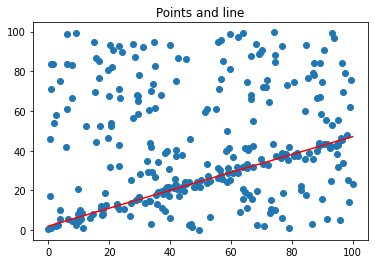

In [34]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y)
ax.plot([0,100], [-l[2] / l[1], -l[0] / l[1] * 100 - l[2] / l[1]], 'r', label='original line')
_ = ax.set_title('Points and line')

In [49]:
best_n = 0          # number of points on the best fit line so far
best_i = 0          # iteration index of best fit line so far
best_inliers = np.array([]) # indices of inliers of the best fit line so far
for i in np.arange(iterations):
    # select two random points
    p = []  # list of random indices for points
    while len(p) != 2:
        p = list(set(np.random.randint(n+k, size=2))) # remove repeated random integers
    p1 = points[p]  # randomly selected points
    x1 = p1[:,0]    # x coordinates
    y1 = p1[:,1]    # y coordinates
    # line equation from the two points using homogenouos coordinates
    l1 = np.array([y1[0] - y1[1], x1[1] - x1[0], x1[0] * y1[1] - x1[1] * y1[0]])
    l1 = l1 / sqrt(l1[0]**2 + l1[1]**2)     # normalize
    # select close points
    inliers = points[np.abs(np.dot(points, l1)) < tolerance]
    if inliers.shape[0] > best_n:
        # better solution found
        best_n = inliers.shape[0]
        best_i = i
        best_inliers = inliers[:,:3].copy()
        best_line = l1.copy()
print(f'Best solution after {best_i} iterations, {best_n} points on line: {best_line}')

Best solution after 104 iterations, 126 points on line: [-0.41745443  0.90869786 -3.48085835]


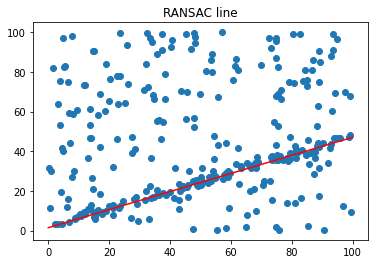

In [48]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(x, y)
ax.plot([0,100], [-best_line[2] / best_line[1], -best_line[0] / best_line[1] * 100 - best_line[2] / best_line[1]], 'r', label='best line')
_ = ax.set_title('RANSAC line')